# Introduction

In this project, I use a combination of models to predict the xEPA (expected expected points added) for the offense at the time of the throw for each route runner in a given play. The goal is to analyze player interactions even when that receiver may not be the target of the quarterback's pass in order to gain insight on which players are most effective at defending pass plays in the NFL.

# Methodology

The first task was to create a multinomial logistic regression model that predicts the probability of a completion, incompletion, and interception for every receiving option in 16,269 pass plays in 2018. A receiving option is defined as an offensive player who runs a route -- the final dataset consists of 77,264 points. The probabilities of a completion, incompletion, and interception are predicted using the following features extracted at the time of the throw:

- The receiver's speed, acceleration, orientation, direction of motion, vertical distance from the sideline, and horizontal distance from the line of scrimmage
- The Euclidean distance between the receiver and the nearest defender
- The nearest defender's direction of motion, acceleration, and speed relative to the receiver
- The quarterback's Euclidean distance from the receiver
- The quarterback's speed
- The available horizontal space for the offense (distance from the opponent's endzone)
- The area of the receiver's bounded Voronoi tessellation (the area of the playing field that is closer to the receiver than any defensive players)
- The model was trained using data from receiving options that were actually targeted.

Next, a separate model was trained on plays in which a pass was completed. The goal of this model was to predict the total yards gained on a completed pass based on a subset of the features used in the prior model. Not only could I predict the probability of the pass being completed, but I could predict the total yards a pass would gain if it were to be completed.

The next step was to train an expected points model. I used nflscrapR's play-by-play data for the 2017 regular season to fit a model that calculates the expected points for the offensive team in any situation and using the aforementioned passing yards model, I could predict the expected points added (EPA) if the pass were to be completed. The same can be done for both incompletions and interceptions.

In short, for all 77,264 points in our dataset, we have the following information:

- Probability of completion if this receiver were targeted
- Probability of incompletion if this receiver were targeted
- Probability of interception if this receiver were targeted
- Predicted expected points added if the pass is completed
- Predicted expected points added if the pass is incomplete
- Predicted expected points added if the pass is intercepted

Thus, we can compute the expected expected points added, or xEPA, for every receiving option in our dataset such that $xEPA = P_{C}\cdot EPA_{C}+P_{INC}\cdot EPA_{INC}+P_{INT}\cdot EPA_{INT}$. 

Shown below is a histogram for each of the components of xEPA along with xEPA itself in the 2018 dataset.



You might be wondering why I'm making things more complicated by taking expected points into consideration instead of solely modeling completion probability. The answer is that completion percentage allowed is a misleading representation of defensive performance. Envision a third down play in which the offense needs to gain ten yards to keep the drive alive. A cornerback allows a 5 yard slant to be completed, but promptly makes the tackle before any yards after the catch could be gained. The offense is forced to punt. That's a positive play for the defender, yet if we just consider the fact that the defender allowed the completion, we'd think they made a poor play. If the same play occured but the defender fails to make the tackle and allows the receiver to break loose for a 15 yard gain, we can properly penalize them by taking into account the offense's increase in expected points on the play. The need to factor expected points into defensive evaluation is even more obvious on plays in which the defense plays soft coverage, such as a play in which the defense elects to play the sticks, or a situation in which prevent defense is being played. Thus, for the purposes of this project, I find it most appropriate to assess defensive performance with xEPA. 

# Defensive Evaluation With xEPA

How can we actually gain insight on pass defense in the NFL using the xEPA data? Before I dive into the data, we have to consider what we're equipped to represent. The xEPA metric gives us a direct means of assessing the quality of pass coverage at the time of the throw. If a player minimizes the distance between themselves and the receiver and maintains 'good' positioning, as determined by the multinomial logistic regression model, they will have a low mean xEPA allowed. However, this skill loses value if the defender lacks the ability to make a play on the ball once it's actually in the air. To paint a more clear picture of NFL pass defense, we must take into account what happens *after* the throw as well.

We can do this by using xEPA to form two important metrics of defensive play:

- **Mean xEPA Allowed (MEPA)**: The mean xEPA of route runners at the time of throw when guarded by a specific defensive player.
- **EPA Allowed Over Expectation (EPAOE)**: The actual EPA allowed by a specific defensive player when they are targeted minus the mean xEPA of the targeted route runners.

MEPA is a **pre-throw** evaluation of individual pass coverage based on *all* plays in which a defensive player is the nearest defender to any offensive route runner.

EPAOE is a **post-throw** evaluation of individual pass coverage based on plays in which a defensive player is the nearest defender to the targeted offensive route runner.

The logic behind the distinction in sample for EPAOE is that we cannot assess what a defender's ability to contest a catch on plays where they're not targeted.

**Player Evaluation**

Shown below is a table of the top ten defenders in MEPA and EPAOE among defenders in the 85th percentile of routes defended or targets defended respectively.

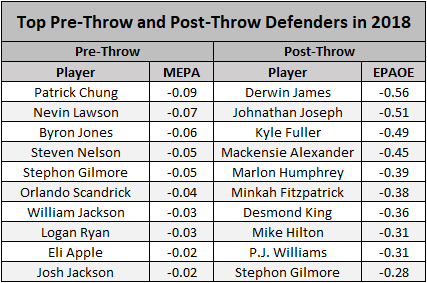

Many of the top EPAOE performers come as no surprise. In 2018, Derwin James was named to the NFL All-Pro First Team in 2018 and his 88.3 overall grade was 3rd highest all-time among rookie safeties, so it's not surprising to see him at the top of the list. Kyler Fuller's superb post-throw rating also makes sense given the fact that he led the league in passes defended. Fuller and Gilmore, the only player in the top ten for both metrics, were also both members of the 2018 NFL All-Pro First Team and Gilmore went on to win the NFL Defensive Player of the Year award in 2018. Yet another All-Pro First Team defender in the top ten for EPAOE is Desmond King, who also earned the highest PFF coverage grade in the league in the 2018 regular season. According to PFF, Fitzpatrick ranked first in passer rating allowed among players with 200 or more coverage snaps in the slot in 2018. Finally, Humphrey knocked passes away at the third-highest rate in the NFL according to PFF. Most of the top performers for EPAOE make sense.

The MEPA results appear to be less directly correlated with defensive success, though. Nevin Lawson's MEPA was the 2nd best in the league among qualifying defensive players in 2018, yet his PFF coverage grade was a subpar 62.5. It's worth noting that PFF coverage grades are only based on plays in which a defensive player is targeted, but you'd still expect Lawson to usually be in a good position to make a play on the ball based on his MEPA, yet this doesn't appear to be the case. Some of the other results check out, though. For instance, William Jackson grades very highly in MEPA and he allowed the 7th-lowest passer rating in a season since 2006 according to PFF. His EPAOE is relatively unimpressive (0.009, which is right around average), suggesting that his defensive success has more to do with his skills pre-throw than his ability to play the ball after the throw. 

The results can also shown with the folowing scatterplot, where MEPA is plotted on the x-axis and EPAOE is plotted on the y-axis.



Most of the results for defensive backs seem reasonable. You may notice, though, that the metrics don't seem to accurately represent pass defense for the linebacker position. Darius Leonard was the Defensive Rookie of the Year in 2018 and while he primarily excelled in run defense, his coverage was certainly not as bad as his MEPA suggests. Luke Kuechly is also one of the greatest inside linebackers we've ever seen, yet his MEPA is quite bad and his EPAOE isn't as impressive as you'd expect. Thus, I believe it's fair to say that the xEPA approach's best use is for the evaluation of defensive backs.


# Future Work

There are many improvements that can be made to this approach. For instance, the model does not adjust for offensive strength at all. The multinomial logistic regression model could account for a prior of quarterback completion percentage based on the length of the throw. A quarterback with a strong arm has a higher likelihood of completing a deep pass than Drew Brees, but this variable is unaccounted in this model. Top cornerbacks are also often matched up against an offense's best receiver, which is another variable of offensive strength that the model fails to account for. Both of these variables would paint a better picture of pass defense in the NFL. The model could also do a better job at accounting for differences in defensive assignments based on scheme distinctions.

While predicting the EPA on a play if the pass is intercepted, the model assumes that the defender will be tackled immediately due to time constraints. A more sophisticated model could predict how many yards the interception would be returned based on similar features. More feature engineering and hyperparameter tuning can also improve the accuracy of the model. 

I believe the data given by the model also has far more applications than those described in this analysis. For instance, we can evaluate offensive performance by rating wide receivers on their ability to get open based on their xEPA, which could also serve as additional context for quarterback performance. Quarterback decision making can be measured by examining the xEPA of all of their options on a given play and judging whether the target they chose to pass to was a good decision relative to their alternative options.

On the defensive side, further analysis can reveal the stability and predictive power of MEPA and EPAOE. For instance, William Jackson had a very successful 2018 season, but mostly due to his MEPA, not his EPAOE. Based on data from previous seasons, his team could determine if his performance is sustainable based on the stability of MEPA as a metric.

In conclusion, I believe that this approach is a solid starting point for evaluating the pass coverage of individual defensive backs. 